<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-06-23-CNN_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2
* also this notebook runs the CNN model twice - once with embedding of 32 (original), one with embedding of 300. At the end of the notebook, it prints a table to compare the two

In [99]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
sys.path.append('drive/My Drive/Springboard/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns

sns.set()


In [0]:
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
MODEL_NAME = "CNN1layerEmbedding32"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"




In [102]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [104]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,48623501,R1G7J2VAMI4AEC,B00LBK7QBY,361030039,universal waterproof case joto cellphone dry b...,Wireless,5,0,0,good product please note not,good product please note not floating case do ...,2015-08-31
1,533148,R3Q4JAPXWCCJU7,B00W661MOO,360205932,car mount alpatronix mx101 universal charging ...,Wireless,5,0,0,great product holds phone place,great product holds phone place does not slip ...,2015-08-31
2,40266813,RJQWVO0QV2WQ4,B00USN9L0E,105913119,synthetic leather galaxy s6 sleeve thin,Wireless,5,0,0,exactly described,quality looks good prompt postage cannot argue...,2015-08-31
3,228806,R3RFPR7X60WN6C,B00YPAOKMU,564491128,jiake s6 5 0 inch unlocked smart phone quad co...,Wireless,5,0,0,powerful attractive really do love mode,works much like jiake phone love price great b...,2015-08-31
4,10866798,R3QL2UPH2B7YFT,B00O0S97SE,742788022,tfy universal car headrest mount holder portab...,Wireless,3,0,1,good enough,serves purpose loud whoever sitting seat attached,2015-08-31


In [0]:
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

## Preprocessing

In [106]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(112043,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [110]:
train_sequences[:2]

[[20,
  24,
  16,
  11,
  1,
  21,
  2629,
  398,
  710,
  67,
  341,
  30,
  2290,
  153,
  140,
  13,
  1,
  28,
  186,
  396,
  20,
  16,
  93,
  370,
  1346,
  408,
  992],
 [99, 70, 31, 1, 168, 44, 1744, 452]]

In [111]:
test_sequences = t.texts_to_sequences(reviews_test)
test_sequences[:2]

[[9,
  608,
  2584,
  670,
  437,
  246,
  2,
  323,
  5,
  31,
  203,
  340,
  1414,
  643,
  342,
  147,
  242,
  272,
  54,
  128,
  278,
  908,
  27],
 [764,
  1621,
  4,
  783,
  2,
  11,
  1,
  149,
  260,
  3,
  914,
  243,
  249,
  2369,
  2,
  9,
  105,
  11,
  3,
  131,
  94,
  128,
  10,
  21]]

In [112]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=40788
Number of Documents=84032


### Sequence Normalization

Figure out max length of review and pad the rest so they are all the same length

In [113]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2864

In [114]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,1.120430e+05,1.120430e+05,112043.000000,112043.000000,112043.000000,112043.000000
mean,2.547598e+07,4.994998e+08,3.889078,0.912435,1.189704,26.322965
std,1.582173e+07,2.879968e+08,1.463196,10.304687,11.167197,47.248166
min,1.014100e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000
25%,1.231110e+07,2.493906e+08,3.000000,0.000000,0.000000,8.000000
50%,2.344848e+07,4.990693e+08,5.000000,0.000000,0.000000,15.000000
75%,4.040851e+07,7.481358e+08,5.000000,0.000000,1.000000,29.000000
max,5.309655e+07,9.999930e+08,5.000000,1447.000000,1524.000000,2864.000000


Looks like 95%+ of our reviews have 186 words or less. If we keep our sequence length to around 64 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [115]:
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
MAX_SEQUENCE_LENGTH

186

In [0]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [117]:
X_train[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [118]:
# this is our star rating column
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

**We are going to run this twice with identical networks. The first will have embedding size of 32. The second will have embedding size of 300. And we will compare results later*

# Building Our First Model with embedding of 32

In [0]:
EMBED_SIZE = 32
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [0]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [121]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 186, 32)           1305248   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 186, 32)           3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 93, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2976)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               744250    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1255      
Total params: 2,053,857
Trainable params: 2,053,857
Non-trainable params: 0
_________________________________________________________________


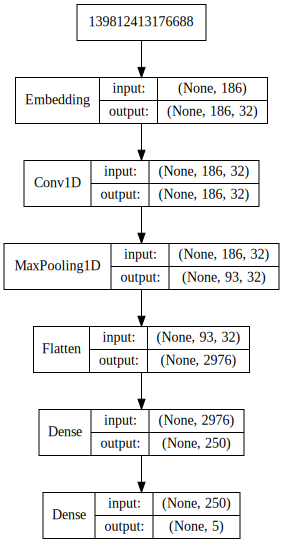

In [122]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [123]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 10s 150us/step - loss: 0.9623 - acc: 0.6317 - val_loss: 0.8650 - val_acc: 0.6667
Epoch 2/50
67225/67225 [==============================] - 9s 139us/step - loss: 0.7634 - acc: 0.7008 - val_loss: 0.8623 - val_acc: 0.6716
Epoch 3/50
67225/67225 [==============================] - 9s 136us/step - loss: 0.6556 - acc: 0.7445 - val_loss: 0.9017 - val_acc: 0.6623
Epoch 4/50
67225/67225 [==============================] - 9s 134us/step - loss: 0.5466 - acc: 0.7918 - val_loss: 1.0303 - val_acc: 0.6553
Epoch 00004: early stopping


In [124]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


28011/28011 [==============================] - 3s 123us/step
Accuracy: 65.88%


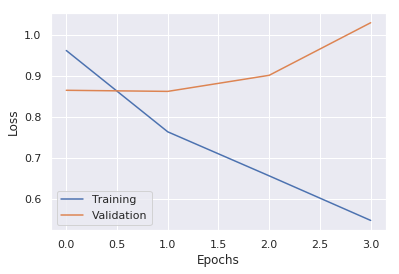

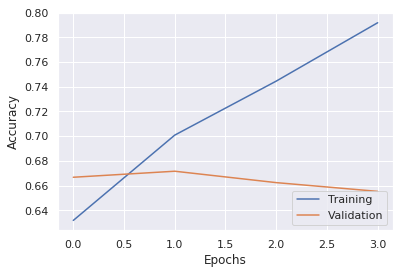

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [0]:
y_predict = model.predict(X_test)

In [127]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.head()

,0,1,2,3,4
0,0.000003,0.000030,0.001750,0.253209,0.745008
1,0.007798,0.021954,0.133277,0.502853,0.334117
2,0.000017,0.000036,0.000447,0.021182,0.978318
3,0.008598,0.007042,0.034529,0.167328,0.782503
4,0.000191,0.000193,0.003071,0.064801,0.931744


In [0]:
y_predict_unencoded = [row.idxmax() + 1 for index, row in y_predict_df.iterrows()]

In [129]:
# unencode the predictions back into it's classes
y_test_df = pd.DataFrame(y_test)
y_test_unencoded = [row.idxmax() + 1 for index, row in y_test_df.iterrows()]
y_test_unencoded[:3]

[5, 5, 4]

In [130]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[ 2910,   309,   329,    81,   339],
       [  737,   243,   445,   175,   271],
       [  431,   196,   712,   527,   665],
       [  136,    74,   448,  1262,  2832],
       [  187,    48,   248,  1080, 13326]])

In [131]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.66      0.73      0.70      3968
           2       0.28      0.13      0.18      1871
           3       0.33      0.28      0.30      2531
           4       0.40      0.27      0.32      4752
           5       0.76      0.90      0.82     14889

    accuracy                           0.66     28011
   macro avg       0.49      0.46      0.46     28011
weighted avg       0.62      0.66      0.63     28011



In [0]:
from sklearn.metrics import roc_curve, auc
import numpy as np


def calculate_roc_auc(y_test, y_score):
  """
  Caculates the false positive rate, true positive rate, and roc_auc
  Return:
    roc_auc - dictinary of AUC values there will be 1 auc per class then a macro 
        and micro for the overall model
        keys: auc_0 to auc_{n_classes} + micro and macro
    fpr - dictionary of FPR, each value will be a n_classes x ? interpolated array 
        so you can plt ROC curve for each class
        keys: 0 to {n_classes} + micro and macro
    tpr - dictionary of TPR, each value will be a n_classes x ? interpolated array 
        so used to plt ROC curve for each class
        keys: 0 to {n_classes} + micro and macro    
  """
  n_classes = y_test.shape[1]
  
  # to compute the micro RUC/AUC, we need binariized labels (y_test) and probability of predictions y_predict_df

  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in np.arange(0, 5):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[i].to_list())
      roc_auc[f'auc_{i + 1}'] = auc(fpr[i], tpr[i])


  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.values.ravel())
  roc_auc["auc_micro"] = auc(fpr["micro"], tpr["micro"])


  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally aveage it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["auc_macro"] = auc(fpr["macro"], tpr["macro"])

  return roc_auc, fpr, tpr

In [0]:

def plot_roc_auc(model_name, roc_auc, fpr, tpr):
  
  for i in np.arange(0, len(fpr.keys()) - 2):
    plt.plot(fpr[i], tpr[i], label=f'Rating {i+1}')
  plt.plot(fpr["micro"], tpr["micro"], label="Micro Average ROC", 
           linestyle=":", linewidth=4, color='pink')
  plt.plot(fpr["macro"], tpr["macro"], label="Macro Average ROC", 
           linestyle=":", linewidth=4, color='black')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  
  space = 0
  for i in np.arange(0, len(fpr.keys()) - 2):
    plt.text(x=0, y=-0.25+space, 
      s=f'Rating {i + 1} AUC: {roc_auc[f"auc_{i + 1}"]}',
      withdash=True)
    space -= 0.05
  plt.text(x=0, y=-0.25+space, 
    s=f'Micro AUC: {roc_auc["auc_micro"]}',
    withdash=True)
  space -= 0.05
  plt.text(x=0, y=-0.25+space, 
    s=f'Macro AUC: {roc_auc["auc_macro"]}',
    withdash=True)
  
  plt.legend(loc='lower right')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title(f'{model_name} ROC AUC')
  


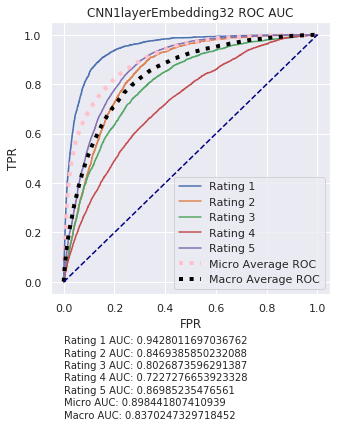

In [134]:
roc_auc, fpr, tpr = calculate_roc_auc(y_test, y_predict_df)
fig = plt.figure(figsize=(5,5))
plot_roc_auc(MODEL_NAME, roc_auc, fpr, tpr)

In [135]:
roc_auc

{'auc_1': 0.9428011697036762,
 'auc_2': 0.8469385850232088,
 'auc_3': 0.8026873596291387,
 'auc_4': 0.7227276653923328,
 'auc_5': 0.86985235476561,
 'auc_macro': 0.8370247329718452,
 'auc_micro': 0.898441807410939}

**Save off various files**

In [0]:
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"
MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'


In [0]:
model.save(MODEL_FILE)

In [0]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [0]:
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened = du.add_dict_to_dict(flattened, roc_auc)
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["tpr"] = tpr
flattened["fpr"] = fpr
flattened["loss"] = scores[0]
flattened["accuracy"] = scores[1]
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["tokenizer_file"] = TOKENIZER_FILE
flattened["max_sequence_length"] = MAX_SEQUENCE_LENGTH
flattened["embedding"] = EMBED_SIZE
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = X_test.shape[0]
flattened["test_features"] = X_test.shape[1]
flattened["train_examples"] = X_train.shape[0]
flattened["train_features"] = X_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [141]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head(20)



,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,auc_1,auc_2,auc_3,auc_4,auc_5,auc_macro,auc_micro,confusion_matrix,description,embedding,file,fpr,loss,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,max_sequence_length,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.705593,0.659724,0.758317,3968.0,0.188988,0.28178,0.142170,1871.0,0.346419,0.327356,0.367839,2531.0,0.342324,0.436014,0.281776,4752.0,0.829797,0.787234,0.877225,14889.0,0.664239,0.948508,0.853672,0.814880,0.741322,0.881056,0.847909,0.904417,[[ 3009 300 380 62 217]\n [ 784 26...,amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,drive/My Drive/Springboard/capstone/data/amazo...,"{0: array([0. , 0. , 0. , .....",0.913675,0.482624,0.498422,0.485465,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,GRU_1layer,drive/My Drive/Springboard/capstone/models/201...,success,2019-07-23 06:06:57,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,"{0: array([0.00000000e+00, 2.52016129e-04, 5.0...",84032.0,186.0,0.643024,0.634272,0.664239,28011.0
1,0.695424,0.661213,0.733367,3968.0,0.177308,0.27931,0.129877,1871.0,0.302143,0.326306,0.281312,2531.0,0.320427,0.403840,0.265572,4752.0,0.824578,0.764412,0.895023,14889.0,0.658777,0.942801,0.846939,0.802687,0.722728,0.869852,0.837025,0.898442,"[[2910, 309, 329, 81, 339], [737, 243, 445, 17...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,32.0,drive/My Drive/Springboard/capstone/data/amazo...,"{0: [0.0, 0.0, 0.0, 4.159214740257039e-05, 4.1...",1.014967,0.463976,0.487016,0.461030,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,CNN1layerEmbedding32,drive/My Drive/Springboard/capstone/models/201...,success,2019-07-23 06:15:08,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,"{0: [0.0, 0.00025201612903225806, 0.0030241935...",84032.0,186.0,0.630313,0.616634,0.658777,28011.0


In [0]:
report_df.to_csv(REPORT_FILE, index=False)

# Second model of this with embedding of size 300 instead of 35

In [0]:
MODEL_NAME300 = "CNN1layerEmbedding300"
EMBED_SIZE300 = 300
model300 = Sequential()
model300.add(Embedding(VOCAB_SIZE, EMBED_SIZE300, input_length=MAX_SEQUENCE_LENGTH))
model300.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model300.add(MaxPooling1D(pool_size=2))
model300.add(Flatten())
model300.add(Dense(250, activation='relu'))
model300.add(Dense(5, activation='softmax'))
model300.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [144]:
print(model300.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 186, 32)           28832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 93, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2976)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               744250    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1255      
Total params: 13,011,037
Trainable params: 13,011,037
Non-trainable params: 0
________________________________________________________________

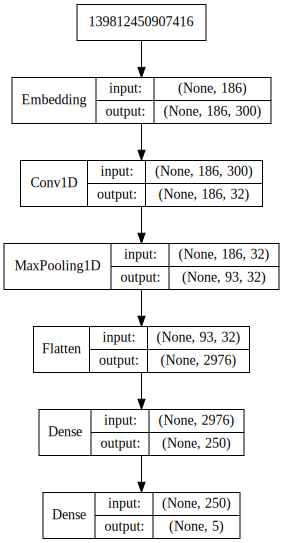

In [145]:
SVG(model_to_dot(model300, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [146]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history300 = model300.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 22s 324us/step - loss: 0.9359 - acc: 0.6397 - val_loss: 0.8580 - val_acc: 0.6645
Epoch 2/50
67225/67225 [==============================] - 20s 304us/step - loss: 0.7343 - acc: 0.7126 - val_loss: 0.8570 - val_acc: 0.6633
Epoch 3/50
67225/67225 [==============================] - 21s 305us/step - loss: 0.5840 - acc: 0.7749 - val_loss: 0.9506 - val_acc: 0.6579
Epoch 4/50
67225/67225 [==============================] - 20s 304us/step - loss: 0.4244 - acc: 0.8424 - val_loss: 1.1534 - val_acc: 0.6275
Epoch 00004: early stopping


In [147]:
scores300 = model300.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


28011/28011 [==============================] - 5s 170us/step
Accuracy: 65.88%


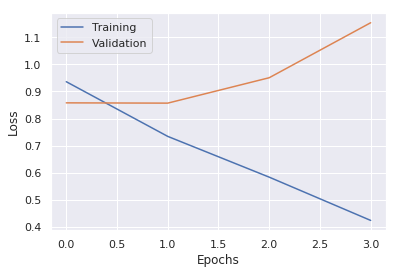

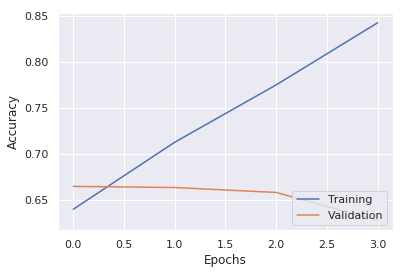

In [148]:
plot_history(network_history300)

In [149]:
y_predict300 = model300.predict(X_test)
y_predict300_df = pd.DataFrame(y_predict300)
y_predict300_df.head()

,0,1,2,3,4
0,0.000002,0.000031,0.004168,0.462182,0.533616
1,0.000519,0.003158,0.083579,0.461356,0.451388
2,0.000575,0.006733,0.061712,0.265173,0.665807
3,0.002156,0.003619,0.135949,0.090206,0.768071
4,0.000103,0.000118,0.003145,0.079801,0.916833


In [0]:
y_predict300_unencoded = [row.idxmax() + 1 for index, row in y_predict300_df.iterrows()]

In [151]:
confusion_matrix(y_test_unencoded, y_predict300_unencoded)

array([[ 2716,   631,   318,    78,   225],
       [  663,   441,   415,   137,   215],
       [  360,   394,   814,   416,   547],
       [  127,   180,   697,  1345,  2403],
       [  248,   142,   505,  1621, 12373]])

In [152]:
print(classification_report(y_test_unencoded, y_predict300_unencoded))

              precision    recall  f1-score   support

           1       0.66      0.68      0.67      3968
           2       0.25      0.24      0.24      1871
           3       0.30      0.32      0.31      2531
           4       0.37      0.28      0.32      4752
           5       0.78      0.83      0.81     14889

    accuracy                           0.63     28011
   macro avg       0.47      0.47      0.47     28011
weighted avg       0.62      0.63      0.62     28011



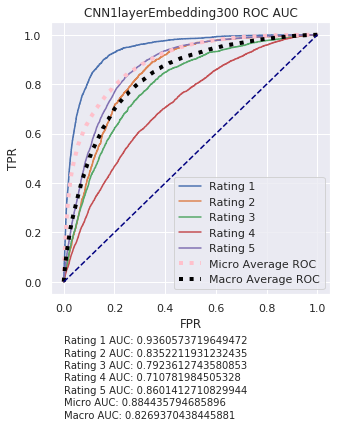

In [153]:
roc_auc300, fpr300, tpr300 = calculate_roc_auc(y_test, y_predict300_df)
fig = plt.figure(figsize=(5,5))
plot_roc_auc(MODEL_NAME300, roc_auc300, fpr300, tpr300)

In [154]:
roc_auc300

{'auc_1': 0.9360573719649472,
 'auc_2': 0.8352211931232435,
 'auc_3': 0.7923612743580853,
 'auc_4': 0.710781984505328,
 'auc_5': 0.8601412710829944,
 'auc_macro': 0.8269370438445881,
 'auc_micro': 0.884435794685896}

In [0]:
# directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME300}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"


MODEL_FILE = f"{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
# REPORT_FILE = f"{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'


In [0]:
model300.save(MODEL_FILE)
pickle.dump(network_history300, open(NETWORK_HISTORY_FILE, "wb"))
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened300 = {}
flattened300 = du.add_dict_to_dict(flattened300, classification_report(y_test_unencoded, y_predict300_unencoded, output_dict=True))
flattened300 = du.add_dict_to_dict(flattened300, roc_auc300)
flattened300["tpr"] = tpr300
flattened300["fpr"] = fpr300
flattened300["loss"] = scores300[0]
flattened300["accuracy"] = scores300[1]
flattened300["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict300_unencoded)
flattened300["description"] = DESCRIPTION
flattened300["file"] = DATA_FILE
flattened300["network_history_file"] = NETWORK_HISTORY_FILE
flattened300["tokenizer_file"] = TOKENIZER_FILE
flattened300["max_sequence_length"] = MAX_SEQUENCE_LENGTH
flattened300["embedding"] = EMBED_SIZE300
flattened300["model_file"] = MODEL_FILE
flattened300["model_name"] = MODEL_NAME
flattened300["test_examples"] = X_test.shape[0]
flattened300["test_features"] = X_test.shape[1]
flattened300["train_examples"] = X_train.shape[0]
flattened300["train_features"] = X_train.shape[1]
flattened300["status"] = "success"
flattened300["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [0]:
report_df = report_df.append(flattened300, ignore_index=True)


In [0]:
report_df.to_csv(REPORT_FILE, index=False)

In [160]:
report_df.T

,0,1,2
1_f1-score,0.705593,0.695424,0.672111
1_precision,0.659724,0.661213,0.660185
1_recall,0.758317,0.733367,0.684476
1_support,3968,3968,3968
2_f1-score,0.188988,0.177308,0.241049
2_precision,0.28178,0.27931,0.246644
2_recall,0.14217,0.129877,0.235703
2_support,1871,1871,1871
3_f1-score,0.346419,0.302143,0.308333
3_precision,0.327356,0.326306,0.296108


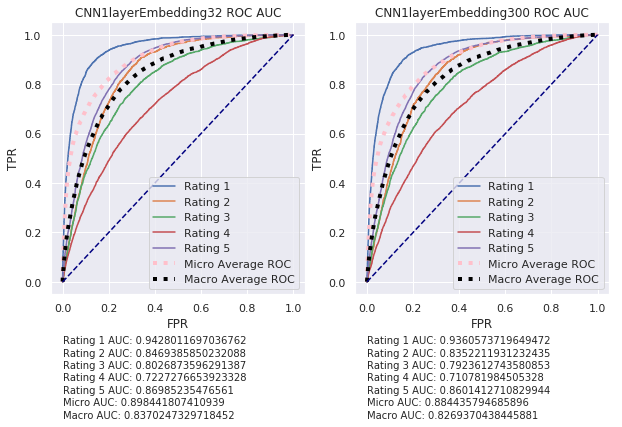

In [161]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2)

ax1  = fig.add_subplot(gs[0,0])
plot_roc_auc(MODEL_NAME, roc_auc, fpr, tpr)

ax2  = fig.add_subplot(gs[0,1])
plot_roc_auc(MODEL_NAME300, roc_auc300, fpr300, tpr300)


**Looks like there is a slight improvement when we increased embedding size  from 32 to 300 for class 1 and 2 but the AUC actually goes down for ratings 3, 4, and 5 slightly**